In [37]:
import tensorflow as tf 
import sys
import os
sys.path.append('../src')
import preprocessing
import seaborn as sns
import cv2
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import matplotlib.pyplot as plt 
import tensorflow as tf
from PIL import Image
import polars as pl
from tensorflow import keras
print(tf.config.list_physical_devices('GPU'))
from keras.callbacks import EarlyStopping, ModelCheckpoint

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:

test_name='test' #@param ["test","test1","test2","test3"]

test_dataset = os.path.join('/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/src/db/', test_name)
classes_path = "classes.txt"

In [9]:
classes_path = "/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/classes.txt"

# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

In [10]:
nb_classes = 3
batch_size=128 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=50 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/src/db/"
input_dim=224
dataset_name='sleepers_db' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
train_dataset = os.path.join(dataset_path, dataset_name)
test_name='test'
test_dataset = os.path.join(dataset_path, test_name)
classes_path = "classes.txt"
classifier = VGG16 #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


In [11]:
def getData(batch_size):
	train_ds = tf.keras.preprocessing.image_dataset_from_directory(
		train_dataset,               # chemin vers le jeu de données
		validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
		subset="training",           # Sélection du jeu de données d'entraînement
		seed=42,                     # Initialisation du générateur aléatoire (permutations)
		image_size = (input_dim,input_dim),   # Taille des images d'entrée
		batch_size = batch_size,   # Taille du mini-batch
		label_mode= 'categorical'    # Conversion au format One-Hot
	)
	val_ds = tf.keras.preprocessing.image_dataset_from_directory(
		train_dataset,               # chemin vers le jeu de données
		validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
		subset="validation",           # Sélection du jeu de données d'entraînement
		seed=42,                     # Initialisation du générateur aléatoire (permutations)
		image_size= (input_dim,input_dim),   # Taille des images d'entrée
		batch_size= batch_size,   # Taille du mini-batch
  		label_mode= 'categorical'    # Conversion au format One-Hot
	)
	return train_ds, val_ds


def get_test(batch_size): 
	test_ds = tf.keras.preprocessing.image_dataset_from_directory(
		test_dataset,               # chemin vers le jeu de données
		seed=42,                     # Initialisation du générateur aléatoire (permutations)
		image_size= (input_dim,input_dim),   # Taille des images d'entrée
		batch_size= batch_size,   # Taille du mini-batch
	label_mode= 'categorical'    # Conversion au format One-Hot
	)
	return test_ds

In [12]:
early_patience = 50
lr = 0.01 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_patience)

!mkdir -p model
model_path = "/mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5"

checkpoint = ModelCheckpoint(model_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max', # Ensure that the best model in terms of val_accuracy is saved
                             verbose=1)
reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
callbacks_list = [early_stopping, checkpoint, reduce_lr_on_plateau]

In [13]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(scale=1./255),
        # keras.layers.RandomFlip("horizontal_and_vertical"),
        # keras.layers.RandomRotation(0.4),
        # keras.layers.RandomZoom(0.3)
    ]
)

def get_model(model) : 
    base_model = model(
        weights='imagenet',
        input_shape=(input_dim,input_dim,3),
        include_top=False
    )
    
    base_model.trainable = False
    inputs = keras.Input(shape=(input_dim, input_dim,3))
    x = data_augmentation(inputs),
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    base_model = keras.Model(inputs,outputs)
    return base_model

2024-03-12 12:29:52.771871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 12:29:52.772069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 12:29:52.772126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 12:29:52.970767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 12:29:52.970858: I external/local_xla/xla/stream_executor

In [14]:
train_ds, val_ds = getData(batch_size)
test_ds = get_test(batch_size)
model = get_model(classifier)
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, epochs=epochs,batch_size=batch_size, validation_data=val_ds, shuffle=True, callbacks=callbacks_list)

Found 2220 files belonging to 3 classes.
Using 1776 files for training.


2024-03-12 12:29:57.322977: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 2220 files belonging to 3 classes.
Using 444 files for validation.
Found 400 files belonging to 3 classes.
Epoch 1/30


2024-03-12 12:30:04.824251: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-12 12:30:05.130447: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-12 12:30:06.969817: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-12 12:30:09.253881: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-12 12:30:09.720239: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

14/14 [==============================] - ETA: 0s - loss: 1.0925 - accuracy: 0.4212
Epoch 1: val_accuracy improved from -inf to 0.53829, saving model to /mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5


/home/faruk/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 297s 15s/step - loss: 1.0925 - accuracy: 0.4212 - val_loss: 0.9001 - val_accuracy: 0.5383 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.6858
Epoch 2: val_accuracy improved from 0.53829 to 0.61261, saving model to /mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5
14/14 [==============================] - 37s 3s/step - loss: 0.8297 - accuracy: 0.6858 - val_loss: 0.7826 - val_accuracy: 0.6126 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.7354
Epoch 3: val_accuracy improved from 0.61261 to 0.65541, saving model to /mnt/c/Users/onerf/Documents/UMons/Master2/Test/src/model/best_model.h5
14/14 [==============================] - 37s 3s/step - loss: 0.7394 - accuracy: 0.7354 - val_loss: 0.7344 - val_accuracy: 0.6554 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.7410
Ep

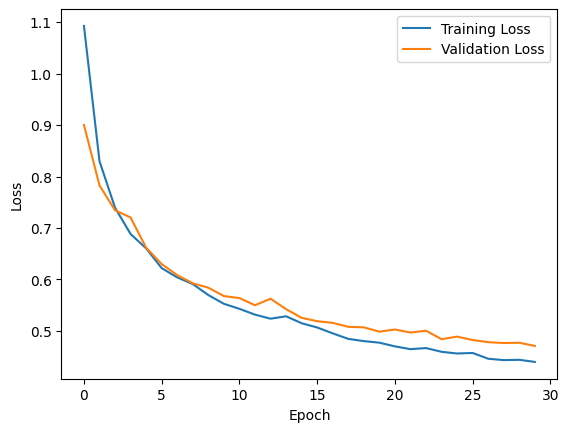

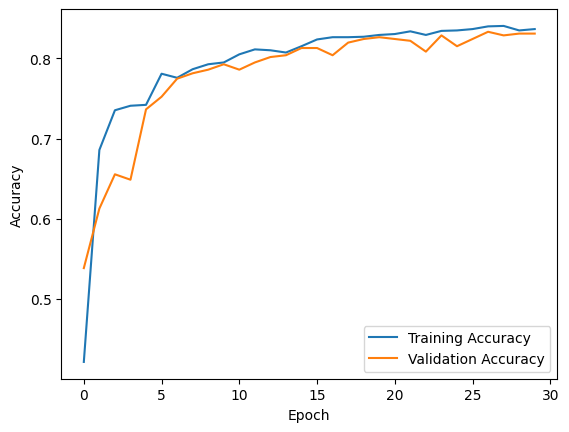

In [15]:
# Visualisation des courbes d'entraînement/validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
eval = model.evaluate(test_ds)
print(f'Test LOSS : {eval[0]*100:.2f}%, Test Accuracy : {eval[1]*100:.2f}%')

4/4 [==============================] - 29s 9s/step - loss: 0.3868 - accuracy: 0.8900
Test LOSS : 38.68%, Test Accuracy : 89.00%


1/1 [==============================] - 5s 5s/step
Class Name : BB1 --- Class Probability: 63.11%
Class Name : MB2 --- Class Probability: 14.11%
Class Name : WS --- Class Probability: 22.78%


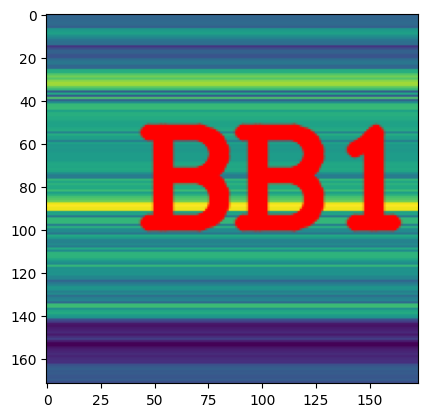

In [39]:
%matplotlib inline

classes = train_ds.class_names
file_path =  '/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/433563.csv'


profil = preprocessing.process_file(file_path)[0]
preprocessing.profil_to_image(profil,file_path,224)
image_path =  '/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/433563.png'
img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

pred = model.predict(x,batch_size=1)[0]


for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()



In [41]:
x

array([[[[ 59.      ,  82.      , 139.      ],
         [ 59.      ,  82.      , 139.      ],
         [ 59.      ,  82.      , 139.      ],
         ...,
         [ 59.      ,  82.      , 139.      ],
         [ 59.      ,  82.      , 139.      ],
         [ 59.      ,  82.      , 139.      ]],

        [[ 52.482143,  96.33929 , 140.95535 ],
         [ 52.482143,  96.33929 , 140.95535 ],
         [ 52.482143,  96.33929 , 140.95535 ],
         ...,
         [ 52.482143,  96.33929 , 140.95535 ],
         [ 52.482143,  96.33929 , 140.95535 ],
         [ 52.482143,  96.33929 , 140.95535 ]],

        [[ 49.419643, 102.74107 , 142.      ],
         [ 49.419643, 102.74107 , 142.      ],
         [ 49.419643, 102.74107 , 142.      ],
         ...,
         [ 49.419643, 102.74107 , 142.      ],
         [ 49.419643, 102.74107 , 142.      ],
         [ 49.419643, 102.74107 , 142.      ]],

        ...,

        [[ 55.25894 ,  90.06247 , 140.58035 ],
         [ 55.25894 ,  90.06247 , 140.58035 ]